In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import random
from scipy.interpolate import interpn
from scipy.spatial import cKDTree
import nbimporter
import subprocess

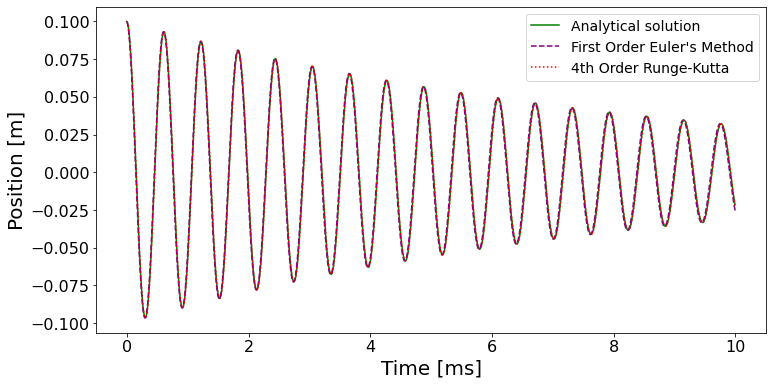

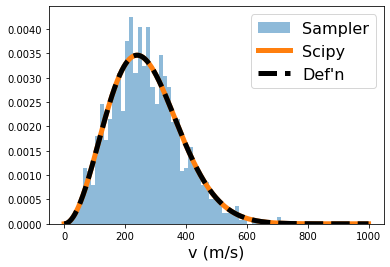

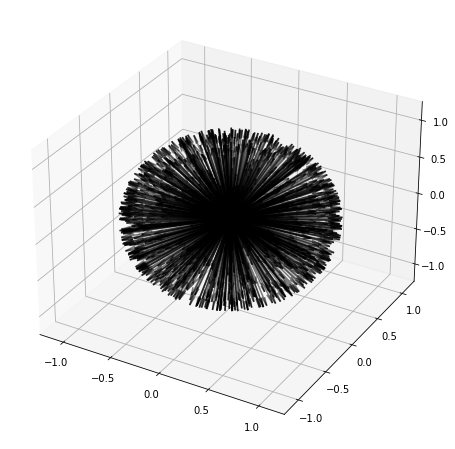

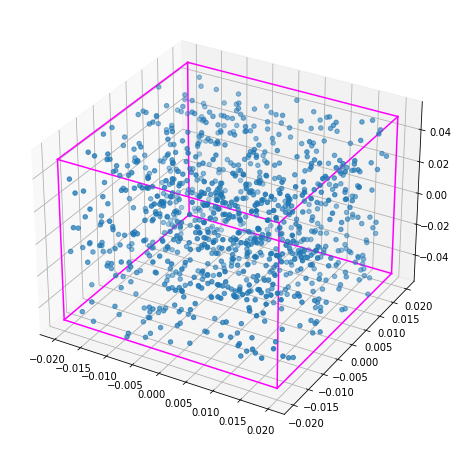

In [61]:
# Import B-field functions
%run CoilCreator.ipynb
# Import simulation functions
%run CesiumMOT.ipynb

# Constants of Parameter Search

In [3]:
# Physical Constants
hbar = 1.055 * 10**(-34) # Js, reduced Planck's constant
light_c = 2.998 * 10**(8) # m/s
BohrMag = 9.27401008 * 10**(-24) # A m^2

# Cesium Specifics
#mass = 2.20694695 * 10**(-25) # kg 
#gamma = 5.22 * 10**(6) # Hz, natural line width of Cs D2 transition. Lam p. 86.
#omega_D2 = 2*np.pi* 351.72571859 * 10**(12) # Hz. Steck p. 15: https://steck.us/alkalidata/cesiumnumbers.1.6.pdf

# Sodium Specifics
mass = 3.817541 * 10**(-26) # kg
gamma = 9.79 * 10**(6) # Hz, natural linewidth of Na D2 transition. 
omega_D2 = 2*np.pi* 508.8487162 * 10**(12) # Hz. Steck p. 18: https://steck.us/alkalidata/sodiumnumbers.pdf

# Apparatus
tube_diam = 1.5 * 10**(-3) # meters, equal to 1.5mm, differential pumping tube diameter
tube_length = 20 * 10**(-3) # meters, equal to 20mm, differential pumping tube length

# Cell dimensions. NaCs 2.0.
x_len = 0.01 # m
y_len = 0.02 # m
z_len = 0.08 # m

# Beams
long_cooling_waist = 30 * 10**(-3) # m. 
short_cooling_waist_x = 0.004 # m.
short_cooling_waist_y = 0.008 # m. 

push_waist = 2.2 * 10**(-3) # m. Equal to 2.2 mm. Circularly symmetric.

# Optimize cesium
#s0_cooling = 23 
#s0_push = 12
#det_x = -1.9*gamma 
#det_y = -1.9*gamma  
#det_push = -1.9*gamma
#det_counter = -3.5*gamma

# Optimize sodium
#s0_cooling = 23 
s0_push = 3
det_x = -1.0*gamma 
det_y = -1.0*gamma  
det_push = -1.0*gamma
det_counter = -3.5*gamma


# Calculation of I_{sat}
I_sat = (hbar * omega_D2**3 * gamma)/(12*np.pi*light_c**2)
coolings0 = 15
CoolingPower_x = (coolings0 * I_sat)*(np.pi * long_cooling_waist * short_cooling_waist_x)/2
CoolingPower_y = (coolings0 * I_sat)*(np.pi * long_cooling_waist * short_cooling_waist_y)/2
print(CoolingPower_x, CoolingPower_y)

0.028166884461105813 0.056333768922211626


# Parameter Search Protocol

(barx, bary, barz) = [6.35, 3.175, 50.8] mm
[0. 0. 0. 0.]


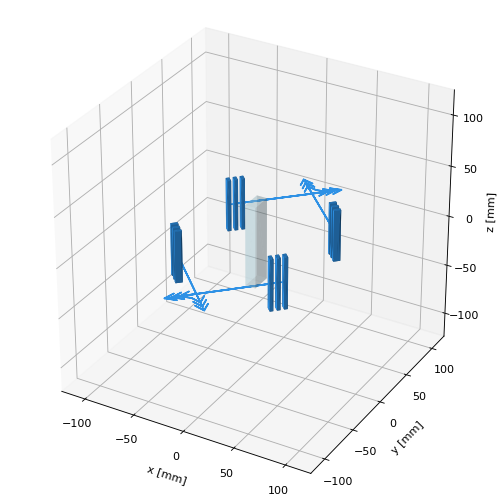

In [69]:
# Better magnet building:

# Magnetization in mT (Remanence field)
## Remanence: Remanence or remanent magnetization or residual magnetism is the magnetization 
## left behind in a ferromagnetic material (such as iron) after an external magnetic field is removed. (Wikipedia)
# Dimension: in mm
# Poisition: in mm
inchtomm = 25.4

barx = (1/4)*inchtomm # mm
bary = (1/8)*inchtomm # mm
barz = 2 * inchtomm # mm

bardims = [barx, bary, barz]
print("(barx, bary, barz) = "+str(bardims)+" mm")

# Neodynmium
rem = 1320 # mT

sidelength = 50 # mm. Half side length
spacer = (1/4)*inchtomm

# Set up magnetic-post configuration
#z_centers = [-30, 30]
z_centers = [0]
# stack
up_stack = 1
down_stack = 1


# Overall collection:
collection = magpy.Collection()
cell = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(10, 20, 80), style={'color':"lightblue", 'opacity':0.25})
collection.add(cell)

def getDim(tolerances=True):
    if tolerances:
        return (barx +0.2*np.random.random()-0.1, bary+0.2*np.random.random()-0.1, barz+0.2*np.random.random()-0.1)
    else:
        return (barx, bary, barz)

# First make one along the z-axis. 
post = magpy.Collection()
for z in z_centers:
    tol = 0.2*np.random.random()-0.1 # [-0.1, 0.1] mm.
    bar1 = magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=getDim(tolerances=True), position=(0, 0, z))
    post.add(bar1)
    for i in range(0, up_stack):
        bar =  magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=getDim(tolerances=True), position=(0, spacer + i*bary, z))
        post.add(bar)
    for i in range(0, down_stack):
        bar =  magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=getDim(tolerances=True), position=(0,-(spacer + i*bary), z))
        post.add(bar)


# Now with post, make four posts
# Make angular offset array:
#ang_offsets = 2*np.random.rand(4)-1
ang_offsets = np.zeros(4)

post1 = post.copy()
post1.rotate_from_angax(-45+ang_offsets[0], axis='z')
post1.move((-sidelength, sidelength, 0))
collection.add(post1)

post2 = post.copy()
post2.rotate_from_angax(-135+ang_offsets[1], axis='z')
post2.move((-sidelength, -sidelength, 0))
collection.add(post2)

post3 = post.copy()
post3.rotate_from_angax(135+ang_offsets[2], axis='z')
post3.move((sidelength, -sidelength, 0))
collection.add(post3)

post4 = post.copy()
post4.rotate_from_angax(45+ang_offsets[3], axis='z')
post4.move((sidelength, sidelength, 0))
collection.add(post4)

print(ang_offsets)
collection.show()

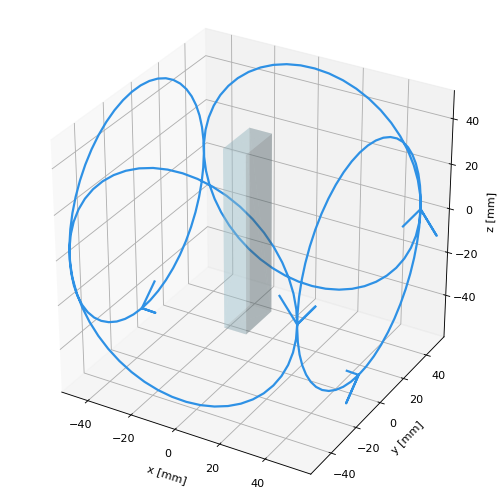

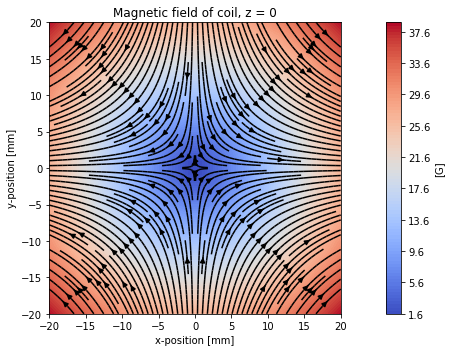

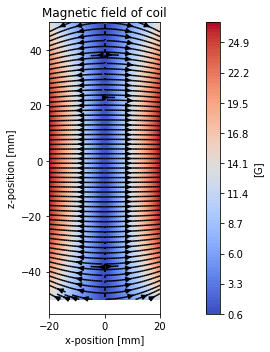

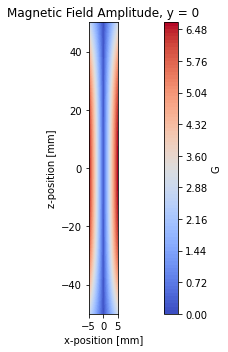

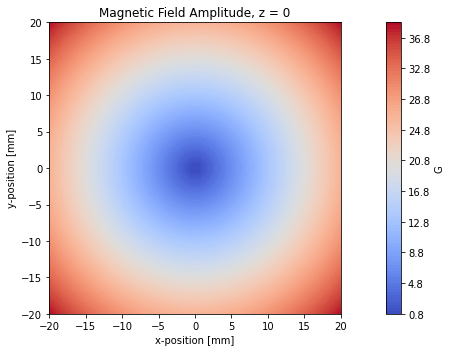

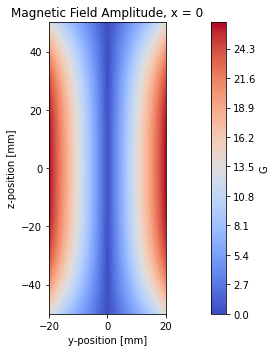

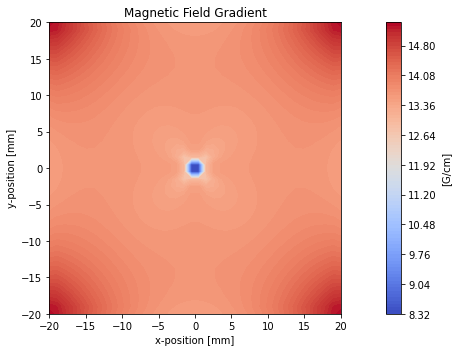

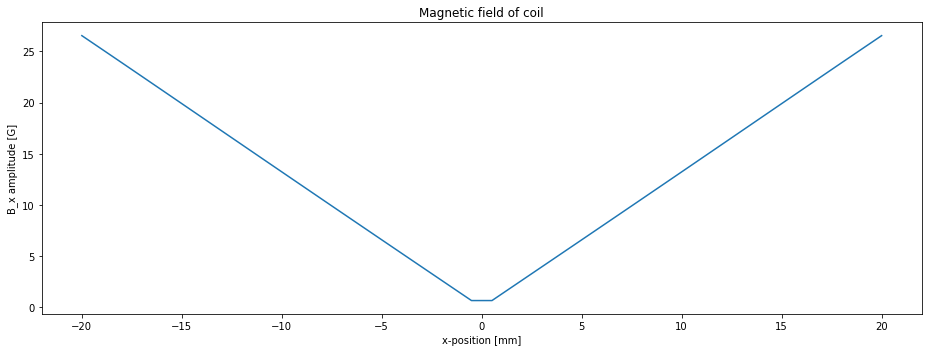

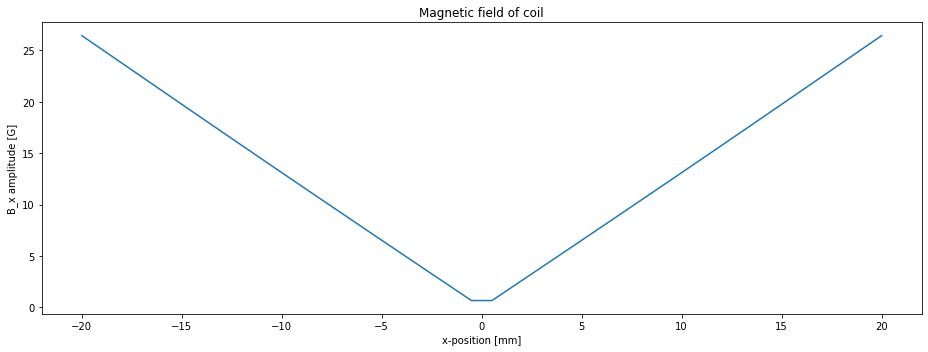

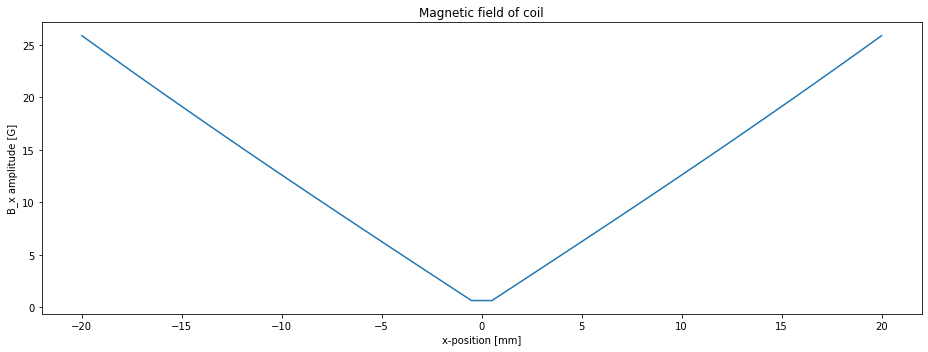

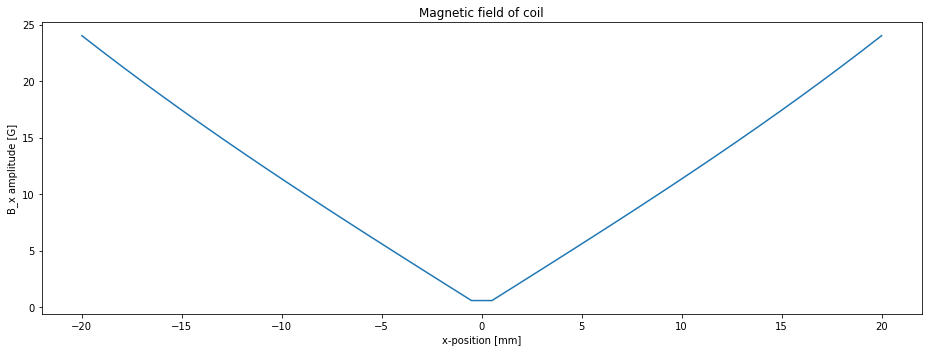

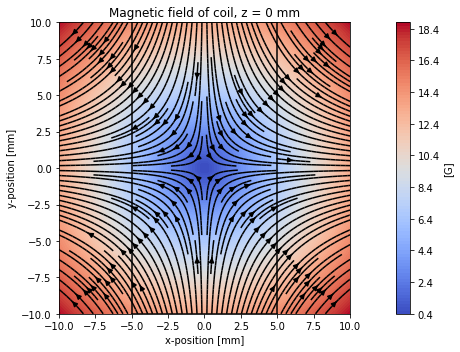

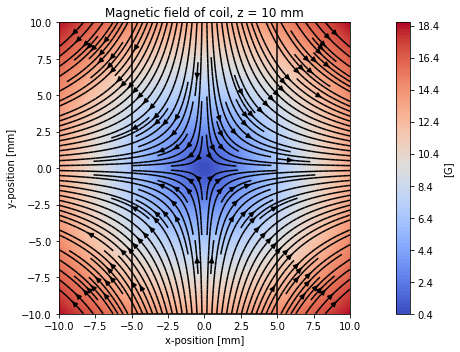

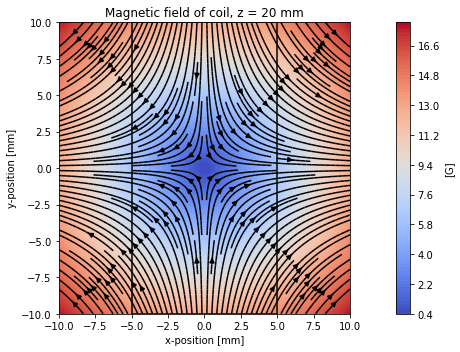

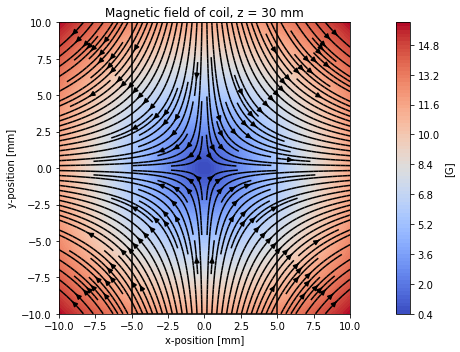

In [77]:
# Generate quadcoil for the run.
quadcoil = makeQuadCoil(winds = 10, dist = 50, diam = 100, curr = 330, width = 1, anti = -1)
cell = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(10, 20, 80), style={'color':"lightblue", 'opacity':0.25})
quadcoil.add(cell)
quadcoil.show()
describeCoil(quadcoil)

cell_x = 10 #mm
cell_y = 20 #mm
cell_z = 80 #mm
def plot_mag_field_xy(coil1, z=0):
    fig, axs = plt.subplots(1, 1, figsize=(13,5))
    
    # create grid
    yts = np.linspace(-1*cell_y/2, 1*cell_y/2, 40)
    xts = np.linspace(-1*cell_y/2, 1*cell_y/2, 40)
    grid = np.array([[(x,y,z) for x in xts] for y in yts])
    
    # compute and plot field of coil2
    B = magpy.getB(coil1, grid)
    Bamp = np.linalg.norm(B, axis=2) * 10
    
    cp = axs.contourf(
        grid[:,:,0], grid[:,:,1], Bamp,
        levels=100,
        cmap='coolwarm',
    )
    axs.streamplot(
        grid[:,:,0], grid[:,:,1], B[:,:,0], B[:,:,1],
        density=2,
        color='black',
    )
    axs.set(
        title='Magnetic field of coil, z = '+str(z)+" mm",
        xlabel='x-position [mm]',
        ylabel='y-position [mm]',
        aspect=1,
    )
    plt.colorbar(cp, ax=axs, label='[G]')
    plt.tight_layout()
    
    
    # Plotting cell on heatmap:
    plt.plot([-cell_x/2, cell_x/2], [cell_y/2, cell_y/2], '-k')
    plt.plot([-cell_x/2, cell_x/2], [-cell_y/2, -cell_y/2], '-k')
    plt.plot([cell_x/2, cell_x/2], [cell_y/2, -cell_y/2], '-k')
    plt.plot([-cell_x/2, -cell_x/2], [cell_y/2, -cell_y/2], '-k')
    
    
    
    plt.show()


plot_mag_amp_line(quadcoil, 0)
plot_mag_amp_line(quadcoil, 10)
plot_mag_amp_line(quadcoil, 20)
plot_mag_amp_line(quadcoil, 30)
plot_mag_field_xy(quadcoil,z=0)
plot_mag_field_xy(quadcoil,z=10)
plot_mag_field_xy(quadcoil,z=20)
plot_mag_field_xy(quadcoil,z=30)

In [16]:
barx = 2.5 # mm
bary = 10 # mm
barz = 2.5 # mm
rem = 1000 # mT


def buildMagnets(includeCell = False):
    collection = magpy.Collection()
    for z in [-25, 0, 25]:
        cell = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(10, 20, 80), style={'color':"lightblue", 'opacity':0.25})
        collection.add(cell)

        bar1 = magpy.magnet.Cuboid(magnetization=(0,-rem,0), dimension=(barx, bary, barz), position=(16, -16, z))
        bar1.rotate_from_angax(-45, axis='z')
        collection.add(bar1)

        bar2 = magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=(barx, bary, barz), position=(16, 16, z))
        bar2.rotate_from_angax(45, axis='z')
        collection.add(bar2)

        bar3 = magpy.magnet.Cuboid(magnetization=(0,-rem,0), dimension=(barx, bary, barz), position=(-16, -16, z))
        bar3.rotate_from_angax(45, axis='z')
        collection.add(bar3)

        bar4 = magpy.magnet.Cuboid(magnetization=(0,rem,0), dimension=(barx, bary, barz), position=(-16, 16, z))
        bar4.rotate_from_angax(-45, axis='z')
        collection.add(bar4)

    return collection

mags = buildMagnets()

In [ ]:
# I'll approximate the "racetrack" as a square. 
# The minimum length and width should be set here.
# I want the enclosure to be a square prism.

cell_x = 10 #mm
cell_y = 20 #mm
cell_z = 80 #mm

# 16 gauge wire
copper_diam = 1.29032 #mm
insulator_thickness = 0.5 #mm (ADJUST)
total_wire_diam = copper_diam + insulator_thickness

# Enclosure boundaries
view_gap = 20 #mm (ADJUST)
enc_length = cell_z + view_gap
enc_width = cell_y + view_gap

# Collection building:
collection = magpy.Collection()

# Build cell:
cell = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(cell_x, cell_y, cell_z), 
                           style={'color':"lightblue", 'opacity':0.25})
collection.add(cell)

# Build enclosure
enclosure = magpy.magnet.Cuboid(magnetization=(0,0,0), dimension=(enc_width, enc_width, enc_length), 
                           style={'color':"black", 'opacity':0.1})
collection.add(enclosure)

# Build a coil:
num_layers = 6
num_in_layer = 8
coil_current = 2.5 # in Amps
total_length = 0
for i in range(0, num_layers):
    for j in range(0, num_in_layer):
        # The layer determines the width and length.
        length = enc_length + j*total_wire_diam
        width = enc_width + j*total_wire_diam
        
        # Keep track of the total_length of the coil
        total_length += 2*length + 2*width
        
        
        # Where is the center of the loop? We should put it half the enclosure width away from the origin, then
        # leave space for the wire diameter, and then increment it by a wire-diameter for each wire
        # we want to add in the layer. This is why there is a (i+1) and not just i.
        mid_position = (enc_width)/2+(i+1)*total_wire_diam
        # Build the vertices of the wire.
        vertices = [(mid_position, width/2, -length/2), (mid_position, width/2, length/2), 
                    (mid_position, -width/2, length/2), (mid_position, -width/2, -length/2), 
                    (mid_position, width/2, -length/2)]
        # Coil on x = pos plane.
        coil1 = magpy.current.Line(coil_current, vertices=vertices)
        collection.add(coil1)
        
        # Next coil (coil on y = pos plane).
        coil2 = magpy.current.Line(-coil_current, vertices=vertices)
        coil2.rotate_from_angax(90, axis='z')
        collection.add(coil2)
        
        # Next coil (coil on x = neg plane)
        coil3 = magpy.current.Line(coil_current, vertices=vertices)
        coil3.rotate_from_angax(180, axis='z')
        collection.add(coil3)
        
        # Next coil (coil on x = neg plane)
        coil4 = magpy.current.Line(-coil_current, vertices=vertices)
        coil4.rotate_from_angax(270, axis='z')
        collection.add(coil4)
        
# Using the total_length of the coil, compute power dissipation.
print(round(total_length/1000, 3), "meters of coil")
rho = 1.7 * 10**(-8) # Ohm-meter, Copper resistivity
Power = (coil_current)**2 * rho * ((total_length/1000)/(np.pi * ((copper_diam/1000)/2)**2))
print("Power dissipated =", Power, " W")

In [71]:
# Generate B-field grid
tree, Bfields = buildBfieldGrid(collection, grid_spacing = 4 * 10**(-4))

B-field Grid shape:  100 x 100 x 250
Step 10 / 100 done. | Total time elapsed = 1.058 seconds
Step 20 / 100 done. | Total time elapsed = 1.505 seconds
Step 30 / 100 done. | Total time elapsed = 1.946 seconds
Step 40 / 100 done. | Total time elapsed = 2.387 seconds
Step 50 / 100 done. | Total time elapsed = 2.849 seconds
Step 60 / 100 done. | Total time elapsed = 3.313 seconds
Step 70 / 100 done. | Total time elapsed = 3.788 seconds
Step 80 / 100 done. | Total time elapsed = 4.249 seconds
Step 90 / 100 done. | Total time elapsed = 4.636 seconds
Step 100 / 100 done. | Total time elapsed = 5.061 seconds
magpylib is calculating B-field on the grid...
B-field calculated on the grid in 7.626  minutes


Starting sim for s0_cooling = 5
Simulating the trajectories of 600000 atoms...
Done with run  0  | Total time elapsed = 0.008 minutes
Done with run  6000  | Total time elapsed = 2.606 minutes
Done with run  12000  | Total time elapsed = 4.078 minutes
Done with run  18000  | Total time elapsed = 5.358 minutes
Done with run  24000  | Total time elapsed = 5.957 minutes
Done with run  30000  | Total time elapsed = 6.828 minutes
Done with run  36000  | Total time elapsed = 7.406 minutes
Done with run  42000  | Total time elapsed = 7.962 minutes
Done with run  48000  | Total time elapsed = 8.616 minutes
Done with run  54000  | Total time elapsed = 9.383 minutes
Done with run  60000  | Total time elapsed = 9.924 minutes
Done with run  66000  | Total time elapsed = 10.438 minutes
Done with run  72000  | Total time elapsed = 10.952 minutes
Done with run  78000  | Total time elapsed = 11.442 minutes
Done with run  84000  | Total time elapsed = 11.929 minutes
Done with run  90000  | Total time el

/Users/ChristianHaroldNunez/opt/anaconda3/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Success at n =  577
Done with run  6000  | Total time elapsed = 0.493 minutes
Done with run  12000  | Total time elapsed = 0.993 minutes
Done with run  18000  | Total time elapsed = 1.491 minutes
Done with run  24000  | Total time elapsed = 1.992 minutes
Done with run  30000  | Total time elapsed = 2.499 minutes
Done with run  36000  | Total time elapsed = 3.012 minutes
Done with run  42000  | Total time elapsed = 3.513 minutes
Done with run  48000  | Total time elapsed = 4.017 minutes
Success at n =  48390
Done with run  54000  | Total time elapsed = 4.515 minutes
Done with run  60000  | Total time elapsed = 5.005 minutes
Done with run  66000  | Total time elapsed = 5.5 minutes
Done with run  72000  | Total time elapsed = 5.999 minutes
Done with run  78000  | Total time elapsed = 6.485 minutes
Success at n =  82835
Done with run  84000  | Total time elapsed = 6.986 minutes
Done with run  90000  | Total time elapsed = 7.503 minutes
Success at n =  95929
Done with run  96000  | Total ti

Done with run  156000  | Total time elapsed = 14.996 minutes
Success at n =  157218
Done with run  162000  | Total time elapsed = 15.545 minutes
Success at n =  162859
Done with run  168000  | Total time elapsed = 16.102 minutes
Done with run  174000  | Total time elapsed = 16.652 minutes
Done with run  180000  | Total time elapsed = 17.217 minutes
Done with run  186000  | Total time elapsed = 17.767 minutes
Success at n =  189429
Done with run  192000  | Total time elapsed = 18.311 minutes
Success at n =  193288
Done with run  198000  | Total time elapsed = 18.891 minutes
Done with run  204000  | Total time elapsed = 19.433 minutes
Done with run  210000  | Total time elapsed = 19.995 minutes
Done with run  216000  | Total time elapsed = 20.557 minutes
Done with run  222000  | Total time elapsed = 21.1 minutes
Done with run  228000  | Total time elapsed = 21.657 minutes
Done with run  234000  | Total time elapsed = 22.236 minutes
Success at n =  236744
Done with run  240000  | Total ti

Done with run  222000  | Total time elapsed = 17.238 minutes
Done with run  228000  | Total time elapsed = 17.699 minutes
Done with run  234000  | Total time elapsed = 18.162 minutes
Done with run  240000  | Total time elapsed = 18.621 minutes
Success at n =  244347
Done with run  246000  | Total time elapsed = 19.108 minutes
Done with run  252000  | Total time elapsed = 19.567 minutes
Done with run  258000  | Total time elapsed = 20.027 minutes
Done with run  264000  | Total time elapsed = 20.496 minutes
Success at n =  264760
Done with run  270000  | Total time elapsed = 20.96 minutes
Success at n =  270857
Done with run  276000  | Total time elapsed = 21.431 minutes
Done with run  282000  | Total time elapsed = 21.896 minutes
Success at n =  283452
Done with run  288000  | Total time elapsed = 22.36 minutes
Done with run  294000  | Total time elapsed = 22.809 minutes
Done with run  300000  | Total time elapsed = 23.268 minutes
Done with run  306000  | Total time elapsed = 23.728 min

Done with run  300000  | Total time elapsed = 23.515 minutes
Success at n =  302654
Done with run  306000  | Total time elapsed = 23.994 minutes
Done with run  312000  | Total time elapsed = 24.463 minutes
Done with run  318000  | Total time elapsed = 24.929 minutes
Done with run  324000  | Total time elapsed = 25.406 minutes
Success at n =  328864
Done with run  330000  | Total time elapsed = 25.884 minutes
Success at n =  335938
Done with run  336000  | Total time elapsed = 26.355 minutes
Done with run  342000  | Total time elapsed = 26.823 minutes
Done with run  348000  | Total time elapsed = 27.296 minutes
Done with run  354000  | Total time elapsed = 27.766 minutes
Done with run  360000  | Total time elapsed = 28.235 minutes
Success at n =  362787
Done with run  366000  | Total time elapsed = 28.71 minutes
Success at n =  371138
Success at n =  371450
Done with run  372000  | Total time elapsed = 29.178 minutes
Done with run  378000  | Total time elapsed = 29.666 minutes
Done with

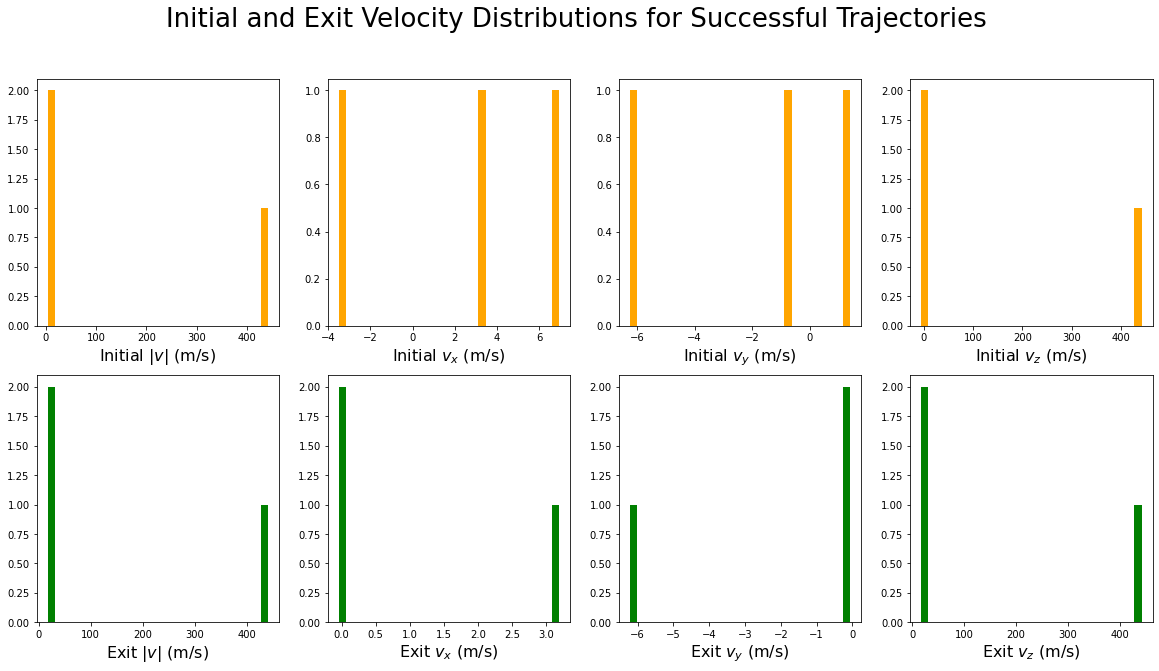

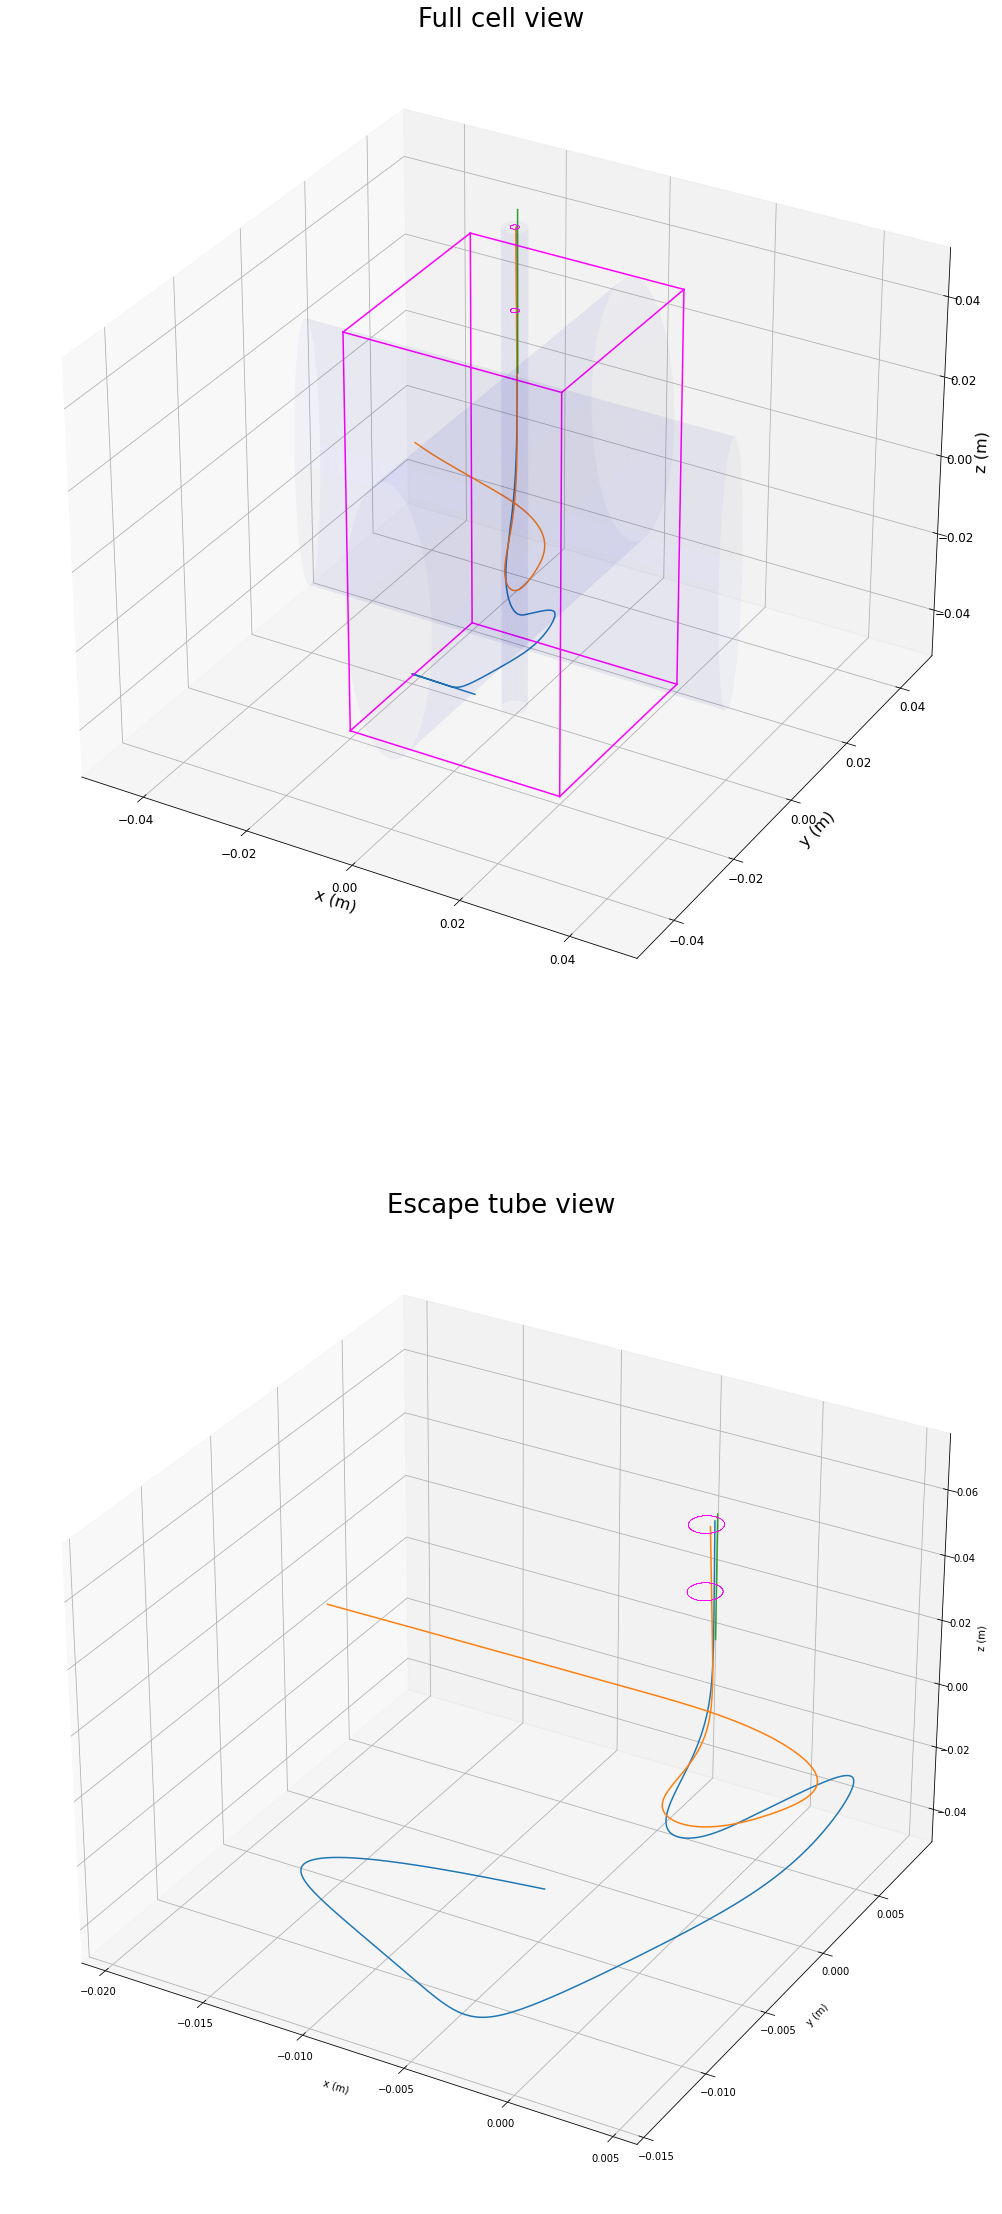

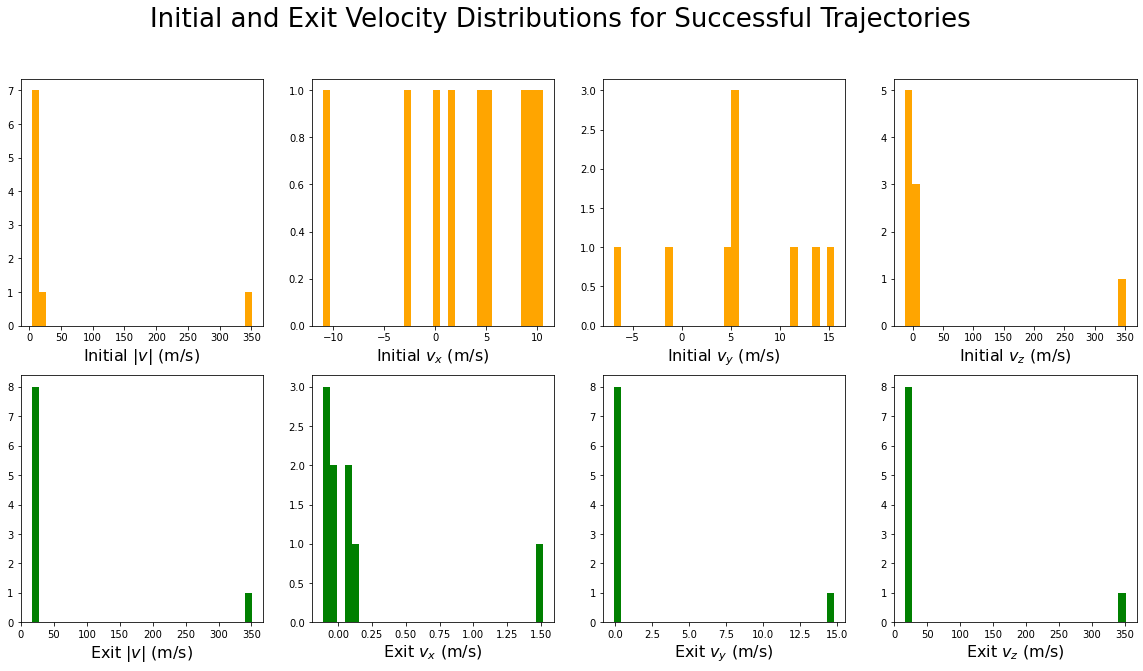

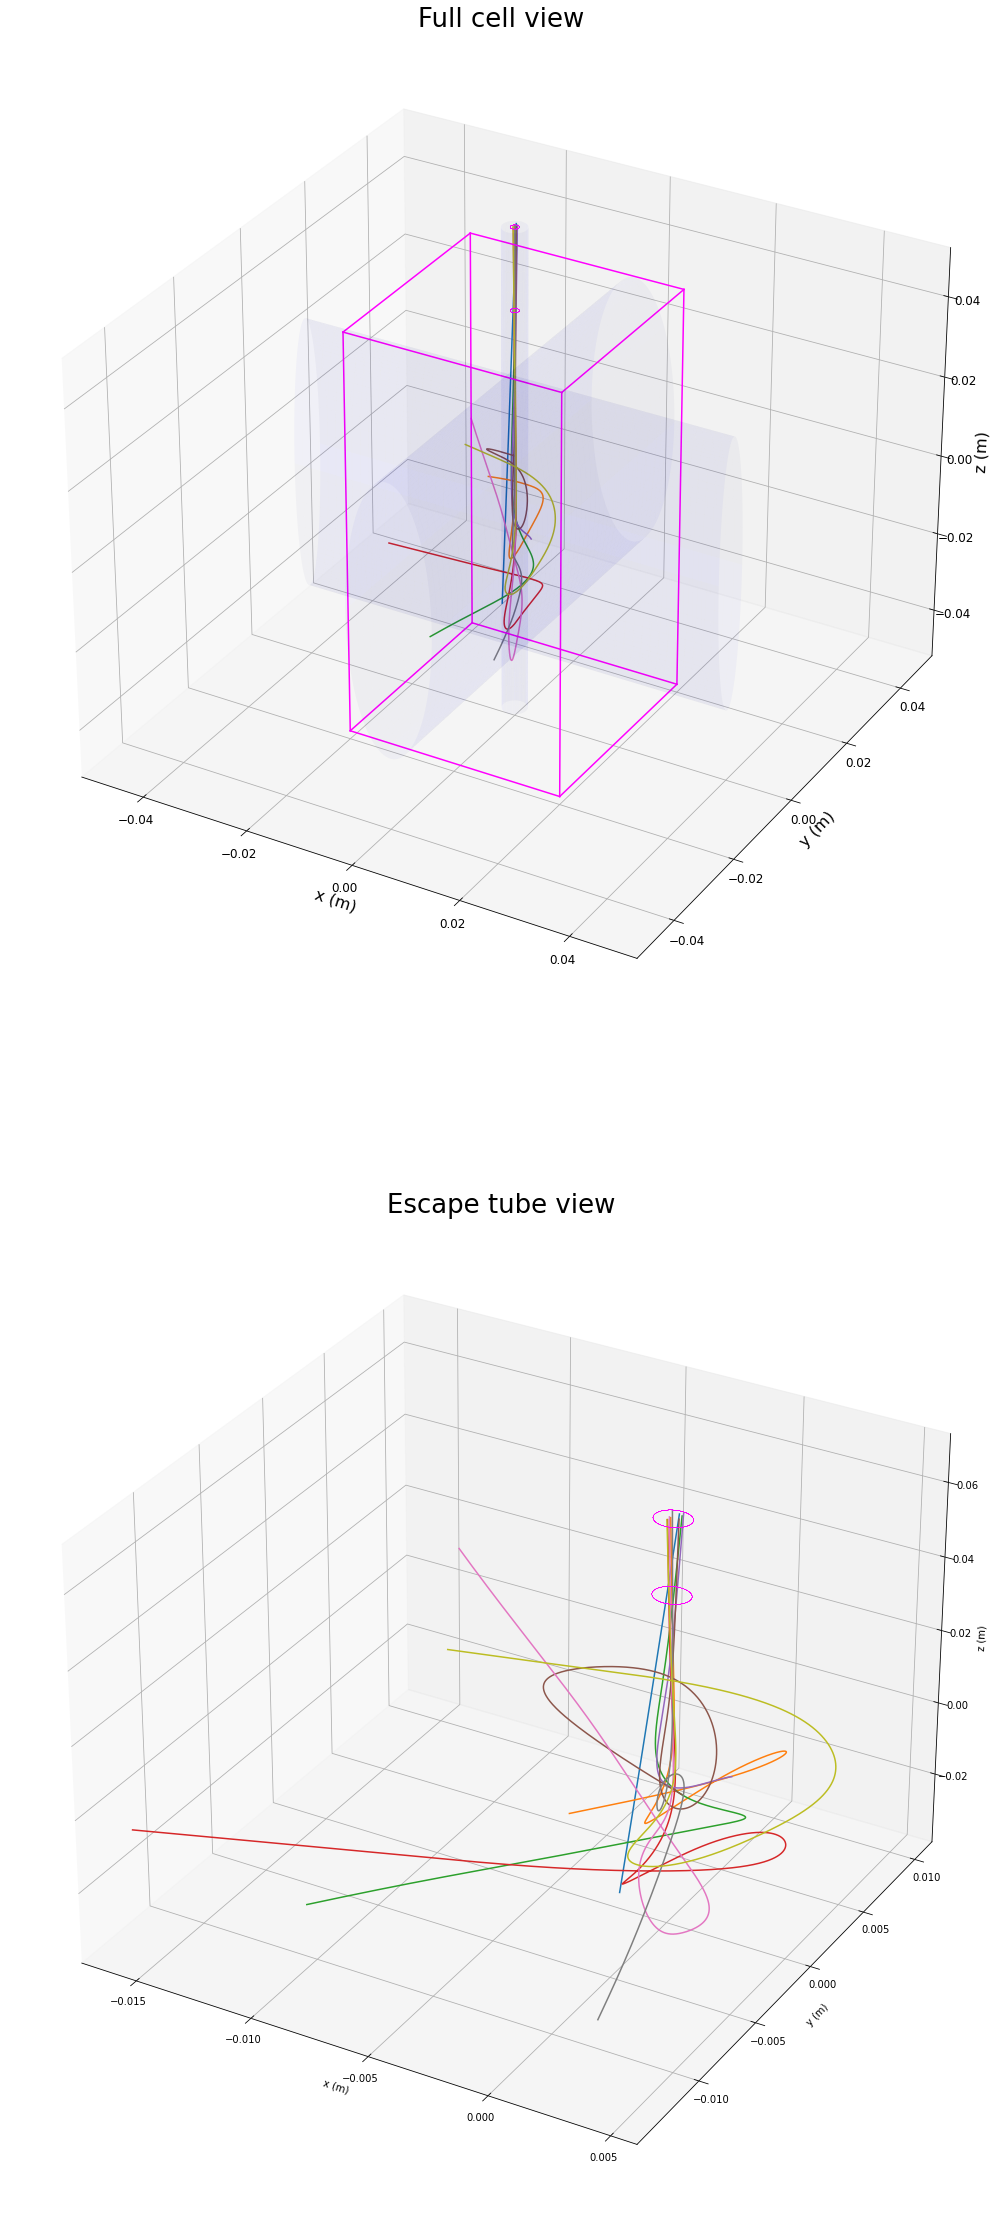

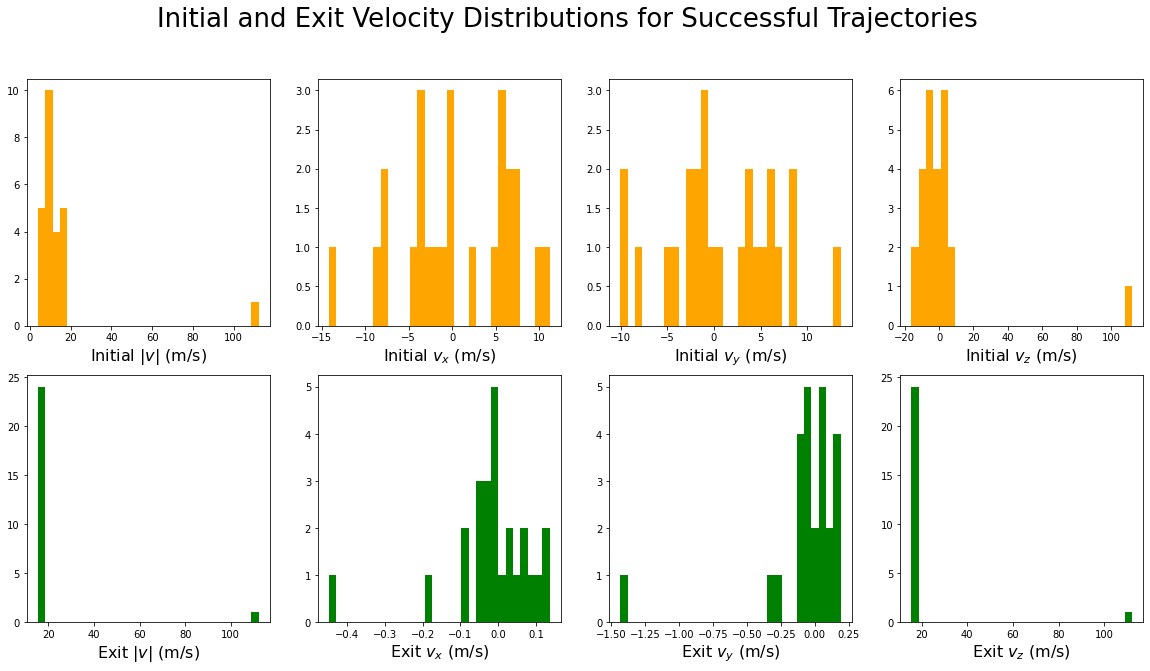

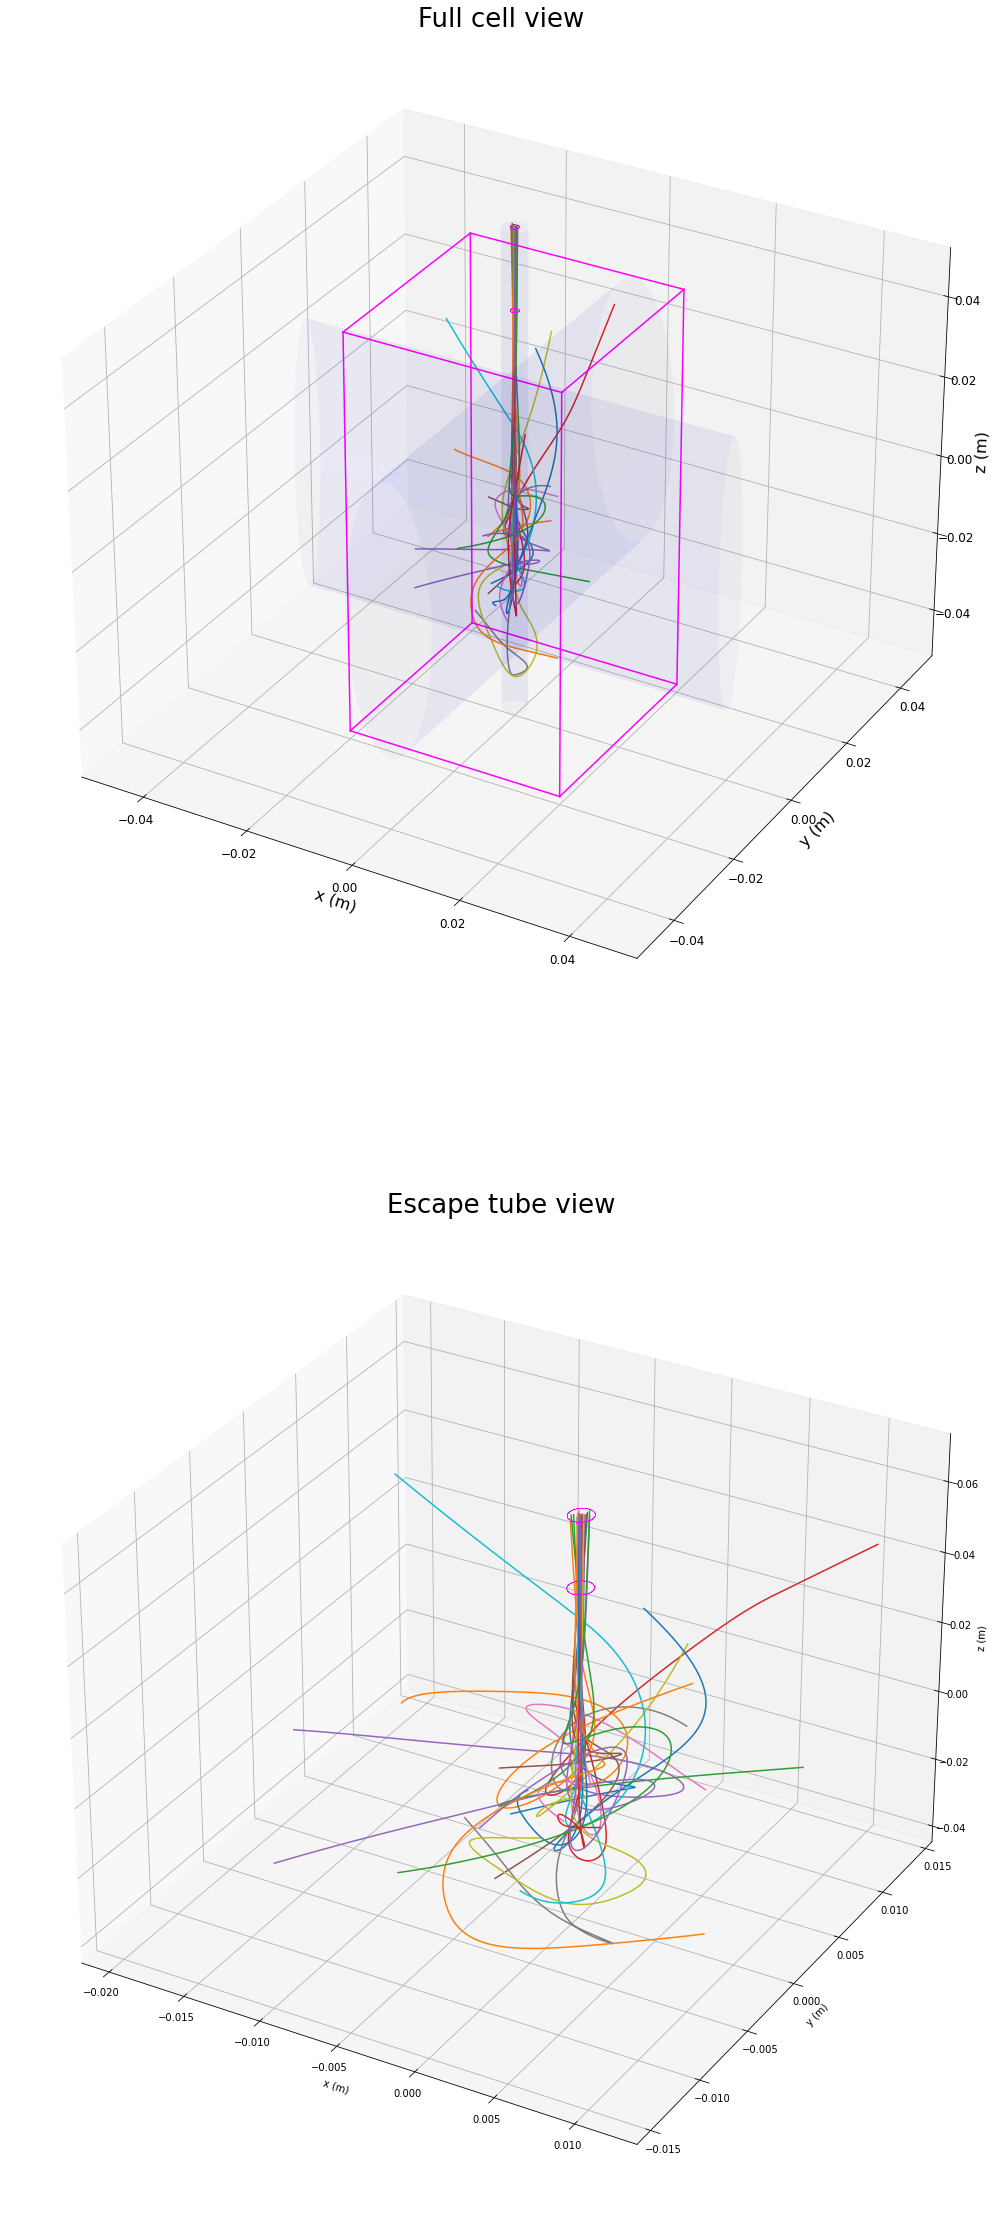

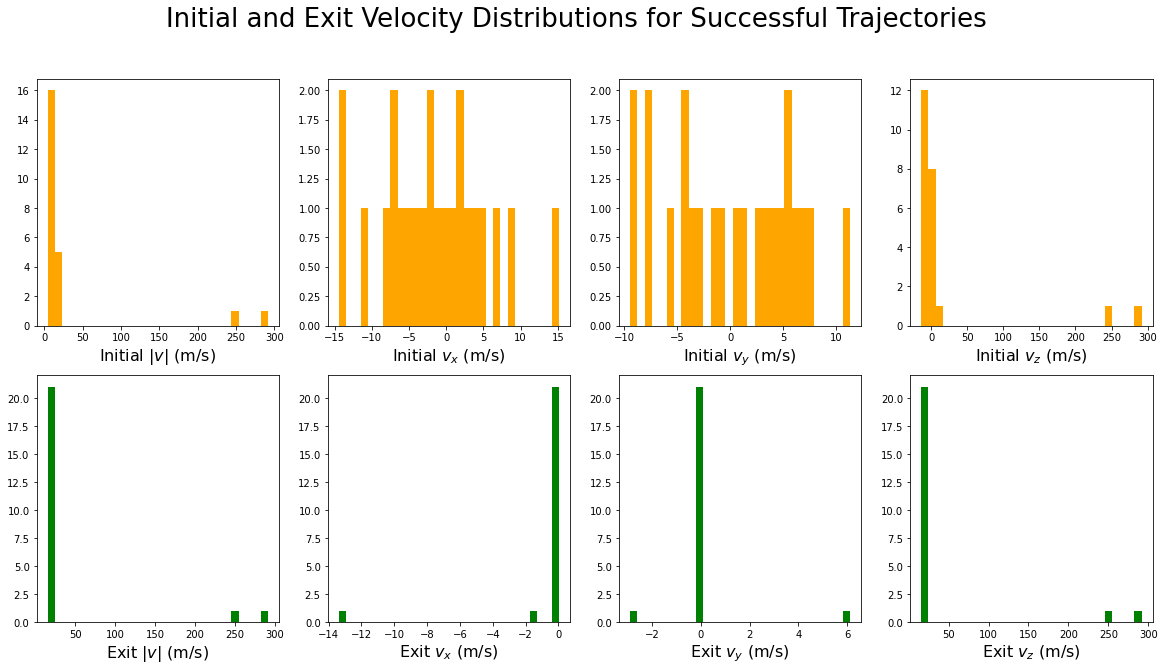

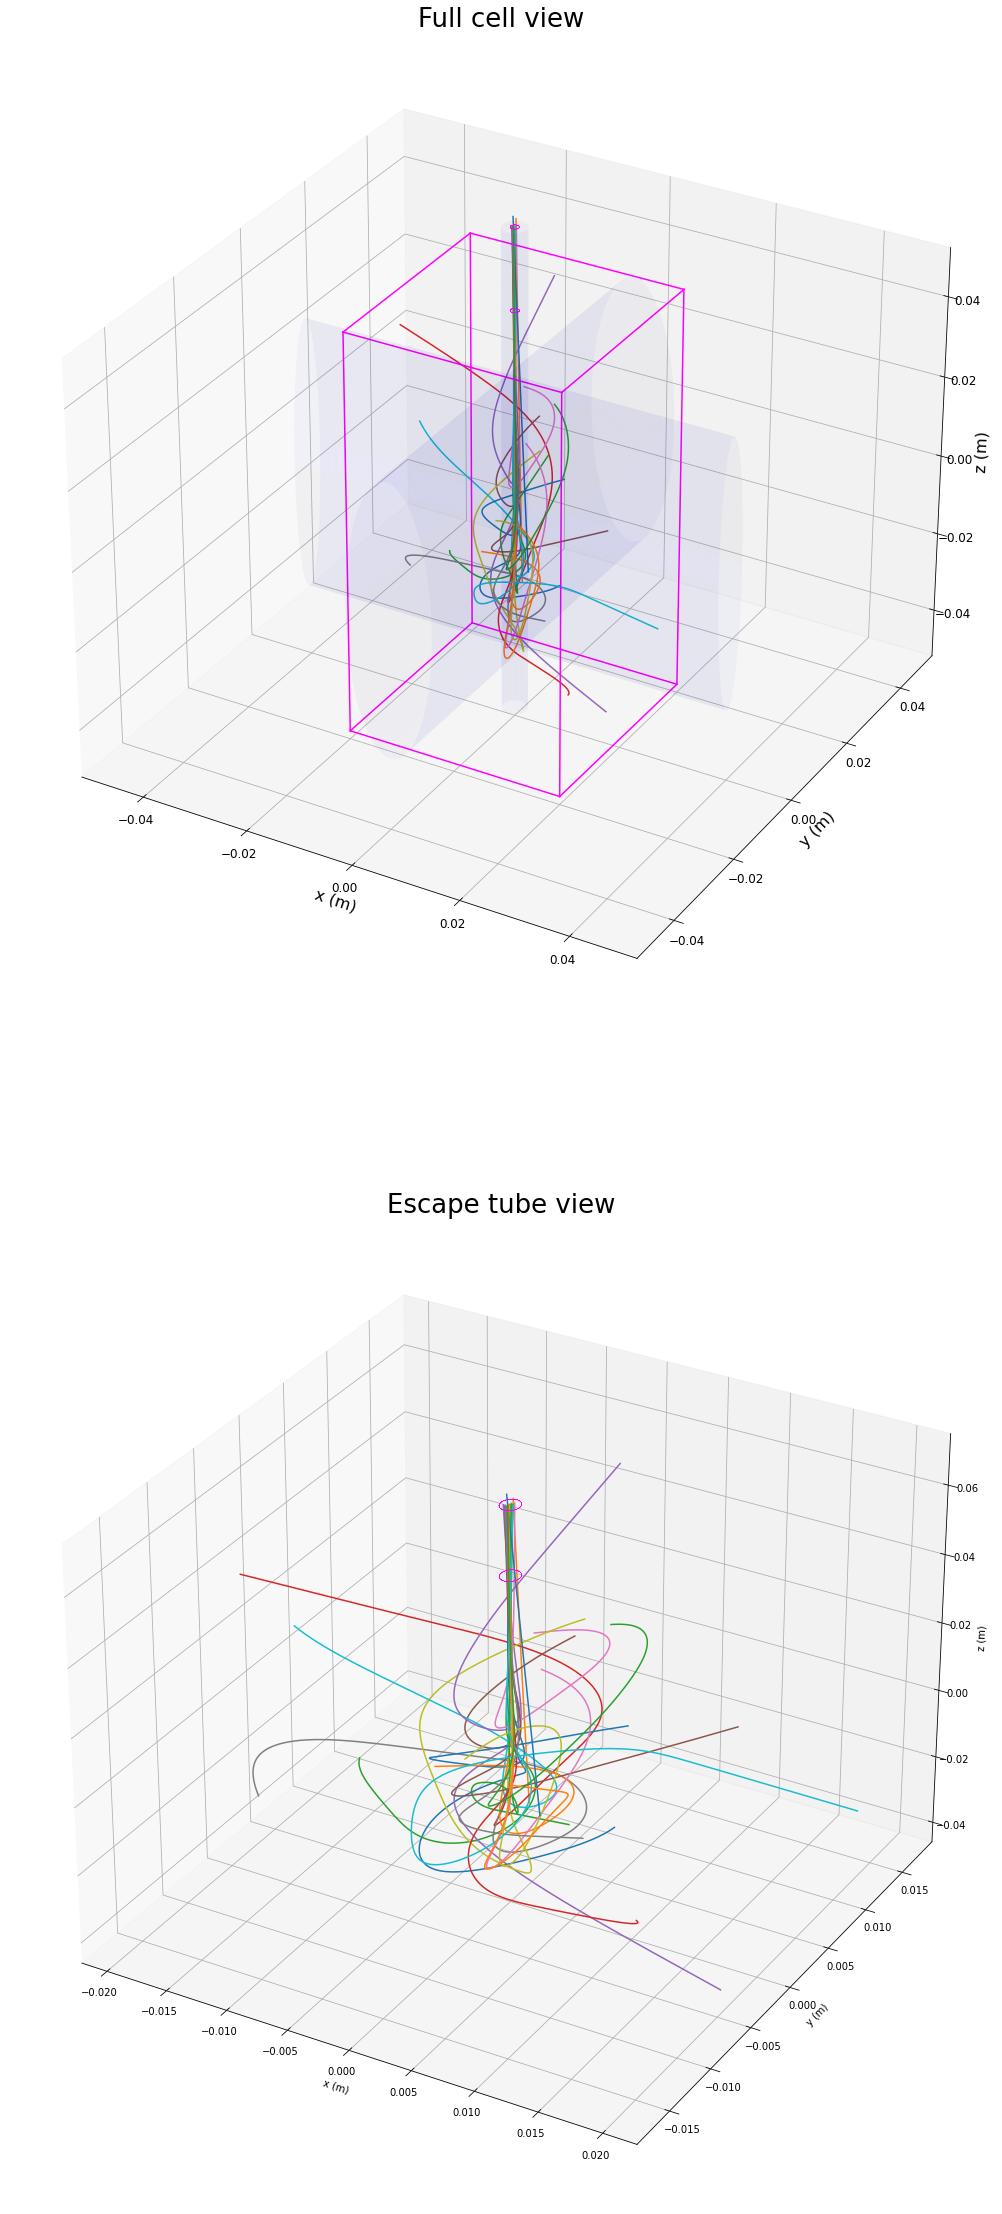

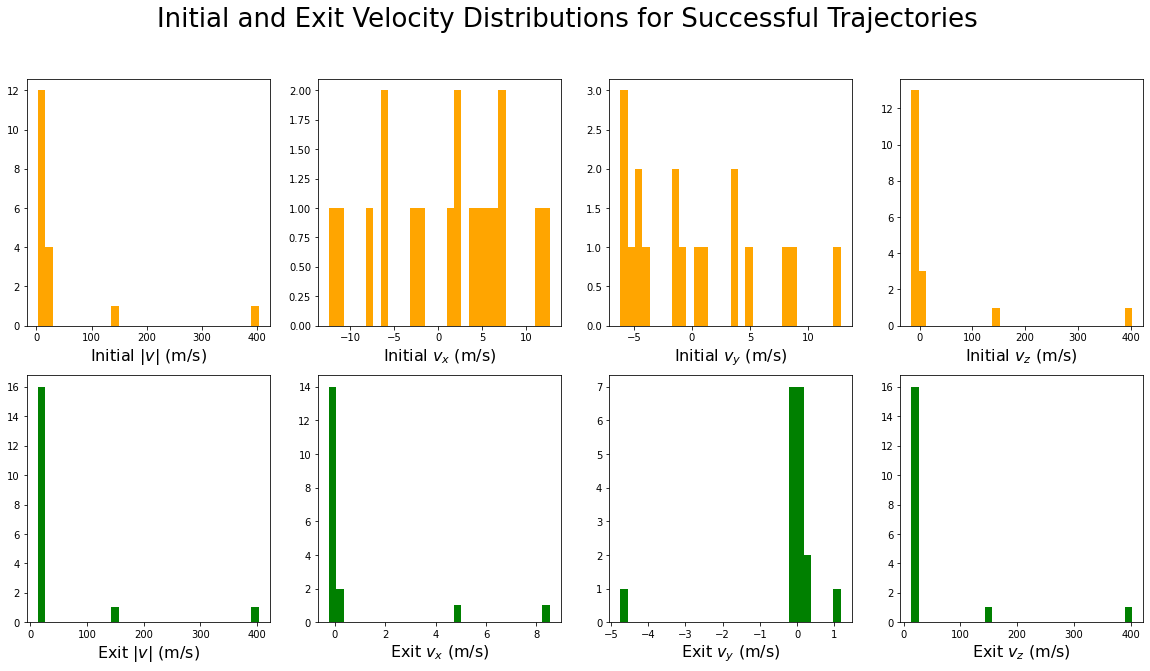

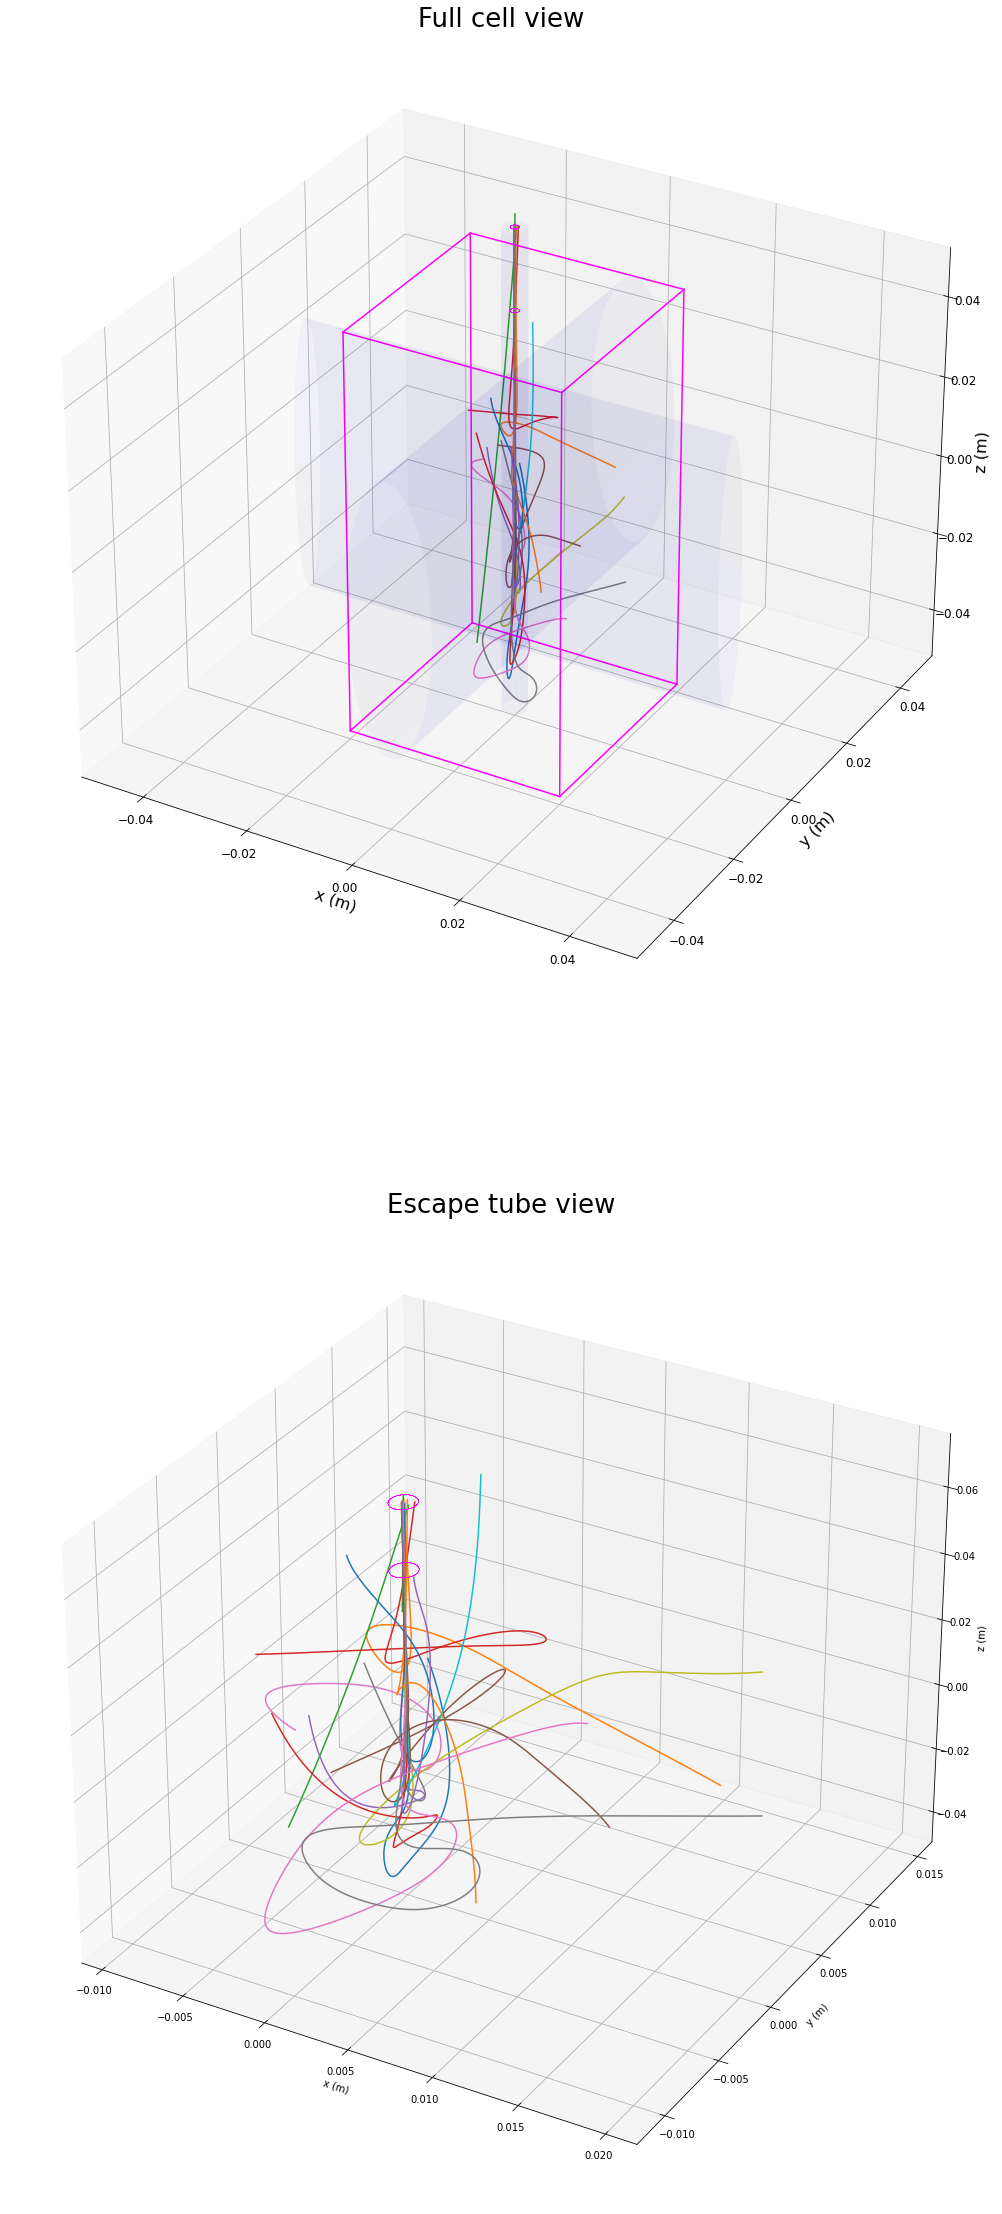

In [80]:
# Let's do a search over push beam intensities.
foldername="Centered_1Up0Down_Na_coolingsearch_push3_600k"
subprocess.Popen("mkdir " + foldername, stdout=subprocess.PIPE, shell=True)
#s0_push_range = [0,2,4,6,8,10,12,14,16, 18, 20] #, 3, 4, 5, 6] # in s0 = I/I_sat units.
s0_cooling_range = [5, 10, 15, 20, 25]
N_sim = 600000
   
# For results: alpha = captures/N_sim
successes_rec = []
capture_efficiencies = []

for s0_cooling in s0_cooling_range:
    subfoldername = foldername+"/s0cooling_"+str(s0_cooling)
    subprocess.Popen("mkdir " + subfoldername, stdout=subprocess.PIPE, shell=True)
    print("Starting sim for s0_cooling =", s0_cooling)
    # Tracking through 2D MOT chamber + tube
    pos_rec, vel_rec, times_rec, forces_rec, success_index, successes = startSim(tree, Bfields, N_sim, verbose=True)
    successes_rec.append(successes)
    
    # Proceed if at least one atom made it through the escape tube.
    if successes > 0:
        #printTrajectory(foldername, pos_rec, vel_rec, forces_rec, times_rec, index=0)
        printHistograms(subfoldername, vel_rec, success_index)
        print3D(subfoldername, pos_rec, success_index)
    
        # Tracking to 3D MOT Chamber
        MOT_tube_zrel = .55 #.55 # m, equal to 55cm.
        captureRadius = .01 # m, equal to 1cm. This is the radius of the 3D MOT capture region.
        dt = 10 * 10**(-6) # s
        captures, positions_record = trackToChamber(MOT_tube_zrel, captureRadius, dt)
        
        capture_efficiencies.append(captures/N_sim)
    else:
        capture_efficiencies.append(0)

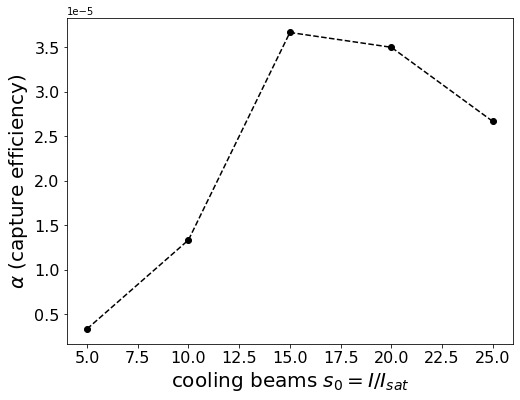

In [81]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(s0_cooling_range, capture_efficiencies, c="k")
plt.plot(s0_cooling_range, capture_efficiencies, "k--")
plt.ylabel(r"$\alpha$ (capture efficiency)", fontsize=20)
plt.xlabel(r"cooling beams $s_0 = I/I_{sat}$", fontsize=20)
ax.tick_params(axis='both', labelsize=16)

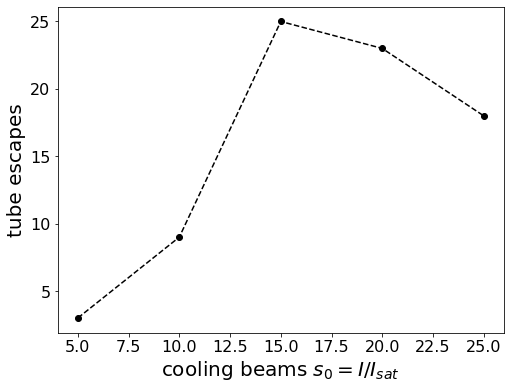

In [82]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(s0_cooling_range, successes_rec, c="k")
plt.plot(s0_cooling_range, successes_rec, "k--")
plt.ylabel(r"tube escapes", fontsize=20)
plt.xlabel(r"cooling beams $s_0 = I/I_{sat}$", fontsize=20)
ax.tick_params(axis='both', labelsize=16)

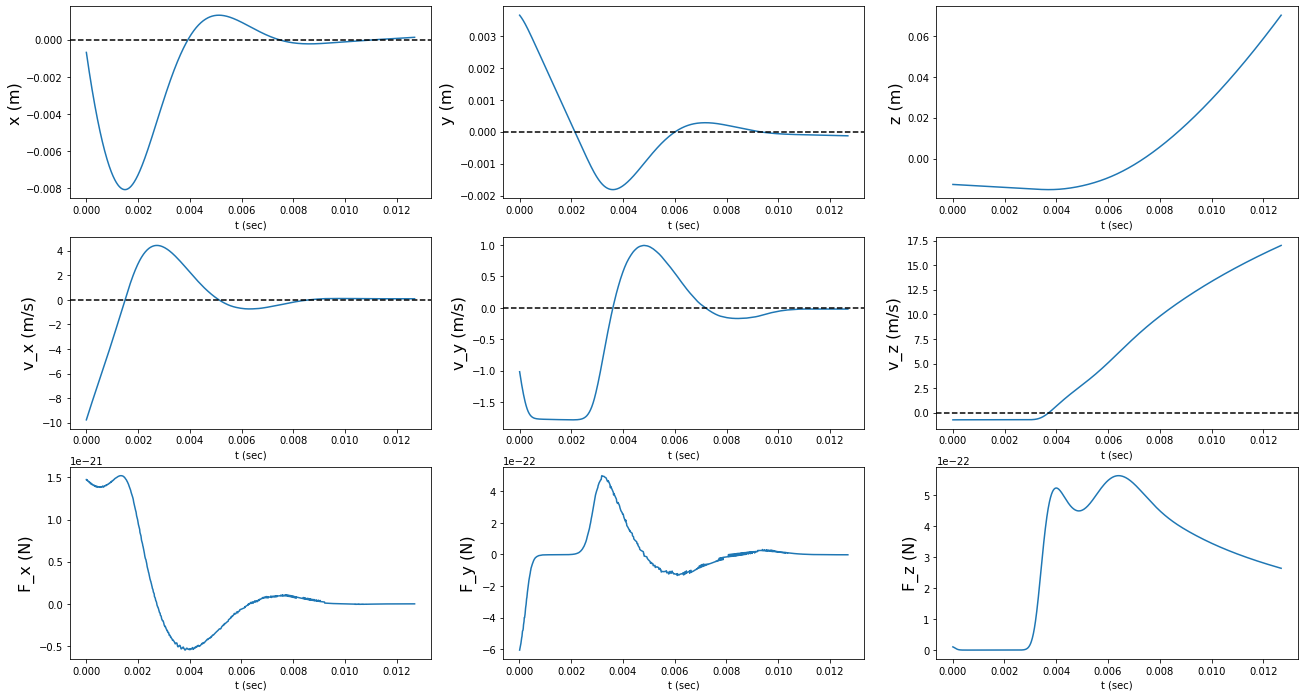

In [79]:
printTrajectory(foldername, pos_rec, vel_rec, forces_rec, times_rec, index=2)

### Parameter search utilities

In [ ]:
# Write run summary
def writeSummary(foldername):
    file = open(foldername+"0_SUMMARY.txt", "w+")
    file.write("===== RUN SUMMARY =====\n")
    file.write("N_sim: " + str(N_sim) + "\n")